In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import functools
import numbers
from IPython import display
import time

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torchvision
from PIL import Image
from torch.nn import functional as F
from torch.utils import data
from torchvision import transforms
import skimage
from skimage.transform import resize as res1

from sklearn.metrics import f1_score

import os

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix



size = lambda x, *args, **kwargs: x.numel(*args, **kwargs)
reduce_sum = lambda x, *args, **kwargs: x.sum(*args, **kwargs)
argmax = lambda x, *args, **kwargs: x.argmax(*args, **kwargs)
astype = lambda x, *args, **kwargs: x.type(*args, **kwargs)

def use_svg_display():
    """Use the svg format to display a plot in Jupyter.

    Defined in :numref:`sec_calculus`"""
    display.set_matplotlib_formats('svg')


class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        """Defined in :numref:`sec_softmax_scratch`"""
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib.

    Defined in :numref:`sec_calculus`"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

class Timer:
    """Record multiple running times."""
    def __init__(self):
        """Defined in :numref:`subsec_linear_model`"""
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()


class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        """Defined in :numref:`sec_softmax_scratch`"""
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        self.num_axes = nrows * ncols
        if self.num_axes == 1:
            self.axes = [self.axes, ]
        xlabel = self._repeat_arg_if_not_iterable(xlabel)
        ylabel = self._repeat_arg_if_not_iterable(ylabel)
        legend = self._repeat_arg_if_not_nested_iterable(legend)
        xlim = self._repeat_arg_if_not_nested_iterable(xlim)
        ylim = self._repeat_arg_if_not_nested_iterable(ylim)
        xscale = self._repeat_arg_if_not_nested_iterable(xscale)
        yscale = self._repeat_arg_if_not_nested_iterable(yscale)
        # Bind arguments with functools
        self.config_axes = [functools.partial(set_axes, self.axes[i], xlabel[i], ylabel[i], 
            xlim[i], ylim[i], xscale[i], yscale[i], legend[i]) for i in range(self.num_axes)]
        self.fmts = fmts
        self.X, self.Y = [None] * self.num_axes, [None] * self.num_axes

    def add(self, x, y):
        if self.num_axes == 1:
            x = [x,]
            y = [y,]
        x = self._repeat_arg_if_not_iterable(x)
        y = self._repeat_arg_if_not_iterable(y)
        for ax_idx, (ax, config_ax, ax_x, ax_y) in enumerate(zip(self.axes, self.config_axes, x, y)):
            # Add multiple data points into the figure
            if not hasattr(ax_y, "__len__"):
                ax_y = [ax_y]
            n = len(ax_y)
            if not hasattr(ax_x, "__len__"):
                ax_x = [ax_x] * n
            if not self.X[ax_idx]:
                self.X[ax_idx] = [[] for _ in range(n)]
            if not self.Y[ax_idx]:
                self.Y[ax_idx] = [[] for _ in range(n)]
            for i, (a, b) in enumerate(zip(ax_x, ax_y)):
                if a is not None and b is not None:
                    self.X[ax_idx][i].append(a)
                    self.Y[ax_idx][i].append(b)
            ax.cla()
            for x, y, fmt in zip(self.X[ax_idx], self.Y[ax_idx], self.fmts):
                ax.plot(x, y, fmt)
            config_ax()
        display.display(self.fig)
        display.clear_output(wait=True)

    def _repeat_arg_if_not_iterable(self, arg):
        if arg is None or isinstance(arg, (str, numbers.Number)):
            return [arg] * self.num_axes
        else:
            return arg

    def _repeat_arg_if_not_nested_iterable(self, arg):
        if arg is None or isinstance(arg, str) or isinstance(arg[0], (numbers.Number, str)):
            return [arg] * self.num_axes
        else:
            return arg

def get_dataloader_workers():
    """Use 4 processes to read the data.

    Defined in :numref:`sec_fashion_mnist`"""
    return 4


def accuracy(y_hat, y):
    """Compute the number of correct predictions.

    Defined in :numref:`sec_softmax_scratch`"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = argmax(y_hat, axis=1)
    cmp = astype(y_hat, y.dtype) == y
    return float(reduce_sum(astype(cmp, y.dtype)))


def evaluate_accuracy_gpu(net, data_iter, device=None):
    """Compute the accuracy for a model on a dataset using a GPU.

    Defined in :numref:`sec_lenet`"""
    if isinstance(net, nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # Required for BERT Fine-tuning (to be covered later)
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), size(y))
    return metric[0] / metric[1]


def evaluate_f1_gpu(net, data_iter, device=('mps')):
    """Compute the f1 score for a model on a dataset using a GPU.

    Defined in :numref:`sec_lenet`"""
    if isinstance(net, nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions

    
    y_tot =[]
    y_hat_tot = []

    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # Required for BERT Fine-tuning (to be covered later)
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            
            
            y_hat = net(X)
            
            y_tot  += y.cpu().data.numpy().tolist()
            y_hat_tot += argmax(y_hat.cpu(), axis=1).data.numpy().tolist()
            
    f1_measure = f1_score(y_tot, y_hat_tot, average="macro")
            

    return f1_measure, y_tot, y_hat_tot



In [2]:
class Resize_1:
    def __init__(self, size):
        if isinstance(size, int):
            self._size = (size, size)

    def change(self, img):
        resize_image = res1(img, self._size)
        # the resize will return a float64 array
        return resize_image

In [3]:
class myDataset_1(torch.utils.data.Dataset):
    """My dataset."""
    def __init__(self, images, labels, resize=None):
        """
        Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        """
        self.labels = labels
        self.images = images
        self.resize = resize
        self.res_func = Resize_1(resize)
        #self.root_dir = root_dir
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        # read image
        #img_name = os.path.join(self.root_dir, self.labels.iloc[idx, 0])
        
        if self.resize:
            image = self.res_func.change(self.images[idx])
        else:
            image = self.images[idx]
            
        image = torch.tensor(image).reshape(-1, self.resize, self.resize).float()
        # read labels
        labels = torch.tensor(self.labels[idx]).long()
        sample = [image, labels]
        return sample

In [4]:
train_ds = myDataset_1(np.load('/Users/dhruvverma/Desktop/ML deployment/data_ml/train_x.npy'), np.load('/Users/dhruvverma/Desktop/ML deployment/data_ml/train_y.npy'), resize=224)
valid_ds = myDataset_1(np.load('/Users/dhruvverma/Desktop/ML deployment/data_ml/val_x.npy'), np.load('/Users/dhruvverma/Desktop/ML deployment/data_ml/val_y.npy'), resize=224)


In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class DenseNet(nn.Module):
    def __init__(self, num_labels=6):
        super(DenseNet, self).__init__()
        
        self.DenseNet = num_labels
        
        self.DenseNet = models.densenet121(pretrained=True)
        
        self.DenseNet.classifier = nn.Sequential(
        nn.Linear(in_features=1024, out_features=num_labels, bias=True)
  )
  
        

    def forward(self, pixel_values):
        outputs = self.DenseNet(pixel_values)

        return outputs

In [6]:
# models.efficientnet_v2_s(pretrained=True)

In [7]:
EPOCHS = 3
BATCH_SIZE = 16
LEARNING_RATE = 2e-5/2

In [8]:
import torch.nn as nn
import torch
# Define Model
model = DenseNet(6)    

for param in model.DenseNet.parameters():
    param.requires_grad = True
# Feature Extractor
#feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
# Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# Cross Entropy Loss
loss_func = nn.CrossEntropyLoss()
# Use GPU if available  
device = torch.device('mps') 


/opt/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
device

device(type='mps')

In [9]:
import torch.utils.data as data

print("Number of train samples: ", len(train_ds))
print("Number of test samples: ", len(valid_ds))
print("Detected Classes are: ", 6) 

train_loader = data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = data.DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=True) 

#train_loader,test_loader = load_data_k_mnist(BATCH_SIZE, resize=32)

print("came here 1")



Number of train samples:  52908
Number of test samples:  8648
Detected Classes are:  6
came here 1


In [10]:
def trainf(net, train_iter, test_iter, loss_func, num_epochs, optimizer, device, scheduler=None, ylim=(None, (0, 1))):
    """Train and evaluate a model with CPU or GPU."""
    net.to(device)
    animator = Animator(xlabel='epoch', xlim=[0, num_epochs], ylim=ylim,
                        legend=[['train loss'], ['train acc', 'train f1', 'val acc', 'val f1'] ],
                        nrows=1, ncols=2, figsize=(10, 4))
    
    animator.add(0, [None, (0, 0, 0, 0)])
    column_names=["Epoch", "Training Loss", "Training Accuracy", "Training F1 Score", "Validation Accuracy", "Validation F1 Score"]
    column_new = ['Epoch', 'Training Loss','Training Accuracy','Training F1']
    metric_dict =  pd.DataFrame([[0,0,0,0,0,0]], columns=column_names)
    dict_dik = pd.DataFrame([[0,0,0,0]],columns=column_new)
    timer = Timer()
    for epoch in range(num_epochs):
        metric = Accumulator(4)  # train_loss, train_acc, train_f1, num_examples
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            net.train()
            
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            loss = loss_func(y_hat, y)
            loss.backward()
            optimizer.step()
            
            
            
            with torch.no_grad():
                metric.add(loss*X.shape[0], accuracy(y_hat, y), f1_score(y.cpu(), argmax(y_hat.cpu(), axis=1), average='macro'), X.shape[0])
            timer.stop()
            train_loss, train_acc, train_f1 = metric[0]/metric[3], metric[1]/metric[3], metric[2]/(i+1)
            if (i+1) % 48 == 0:
                new_row = {"Epoch":epoch+1, "Training Loss":train_loss, "Training Accuracy":train_acc , "Training F1 Score":train_f1}
                dict_dik = dict_dik.append(new_row, ignore_index=True)
                print(f'epoch {epoch:.0f}, step {(i+1):.0f}, training loss {train_loss:.5f}, train acc {train_acc:.5f}, train f1 {train_f1:.5f}'+'\n')
                animator.add(epoch + i/len(train_iter), [train_loss, (train_acc, train_f1, None, None)])
                

        if scheduler:
            scheduler.step()
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        test_f1, _, _ = evaluate_f1_gpu(model, test_loader)
        #metric_dict[("Epoch "+str(epoch))] = 'training loss : '+str(round(train_loss, 5))+' ,train acc : '+str(round(train_acc, 5))+' ,train f1 : '+str(round(train_f1, 5))+' ,test acc : '+str(round(test_acc, 5)+' ,test f1 : '+str(round(test_f1, 5)))
        new_row = {"Epoch":epoch+1, "Training Loss":train_loss, "Training Accuracy":train_acc , "Training F1 Score":train_f1 , "Validation Accuracy":test_acc, "Validation F1 Score":test_f1}
        metric_dict = metric_dict.append(new_row, ignore_index=True)
        print(f'epoch {epoch:.0f}, training loss {train_loss:.5f}, train acc {train_acc:.5f}, train f1 {train_f1:.5f}, val acc {test_acc:.5f}, val f1 {test_f1:.5f}'+'\n')
        animator.add(epoch + 1, [None, (None, None, test_acc, test_f1)])
        
    

    print("")
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec 'f'on {str(device)}')
    print("")
    
    metric_dict = metric_dict.drop([0])
    
    return metric_dict,dict_dik
    
    


0.8 examples/sec on mps



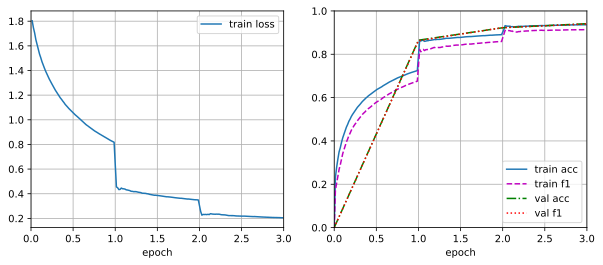

In [12]:
tr_df,my_df = trainf(model, train_loader,test_loader , loss_func, EPOCHS, optimizer, device)

In [13]:
tr_df

,Epoch,Training Loss,Training Accuracy,Training F1 Score,Validation Accuracy,Validation F1 Score
1,1.0,0.813313,0.726128,0.677329,0.865056,0.862695
2,2.0,0.348837,0.890527,0.859197,0.922525,0.922989
3,3.0,0.204517,0.936475,0.914059,0.941374,0.939991


In [14]:
torch.save(model, "densenet3_16_3epochh_hlr.pt")

In [15]:
tr_df.to_csv('densenet3_16_3epoch_hlr.csv', sep='\t',encoding='utf-8')

In [16]:
my_df.to_csv('densenet3_16_steps_3epoch_hlr.csv', sep='\t',encoding='utf-8')

In [16]:
#loading testing set

ds_test = myDataset_1(np.load('/Users/dhruvverma/Desktop/ML deployment/Assignment 2/test_new_Prod_data_fin/test_new_x_fin.npy'), np.load('/Users/dhruvverma/Desktop/ML deployment/Assignment 2/test_new_Prod_data_fin/test_new_y_fin.npy'), resize=224)

In [17]:
test_loader  = data.DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=True)

In [18]:
mod1 = torch.load("/Users/dhruvverma/Desktop/ML deployment/Assignment 2/densenet_16/densenet3_16.pt")

In [19]:
evaluate_accuracy_gpu(mod1, test_loader)

0.4397871688868473

In [20]:
test_f1, y_t, y_h_t = evaluate_f1_gpu(mod1, test_loader)

In [21]:
test_f1

0.35125673820504816

In [22]:
all_f1s_test = f1_score(y_t, y_h_t, average=None)

In [23]:
all_f1s_test

array([0.63801209, 0.09795412, 0.18756371, 0.13556635, 0.52599584,
       0.52244832])

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [25]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_t, y_h_t)
np.set_printoptions(precision=2)

In [26]:
cls_names = ['ANGER', 'DISGUST', 'FEAR', 'HAPPINESS', 'SADNESS', 'SURPRISE']

Confusion matrix, without normalization
[[2375    1   66  381  494  110]
 [  26   79    1  821  458    9]
 [ 214    5  184  371  300  288]
 [   5    7    4  684   18   40]
 [1140  104  278 4027 4932 1458]
 [ 258   23   67 3049  612 3235]]


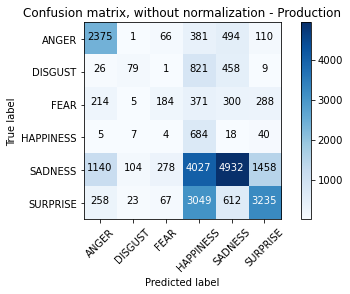

In [27]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=cls_names, title='Confusion matrix, without normalization - Production')
plt.show()
plt.close()



Normalized confusion matrix
[[0.69 0.   0.02 0.11 0.14 0.03]
 [0.02 0.06 0.   0.59 0.33 0.01]
 [0.16 0.   0.14 0.27 0.22 0.21]
 [0.01 0.01 0.01 0.9  0.02 0.05]
 [0.1  0.01 0.02 0.34 0.41 0.12]
 [0.04 0.   0.01 0.42 0.08 0.45]]


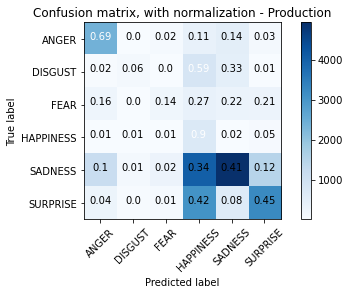

In [28]:
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True, classes=cls_names, title='Confusion matrix, with normalization - Production')
plt.show()
plt.close()